# The Golden (Hour) State:
## *California Solar Irradiance Analysis Using Meteorological Data from 1998-2019*



### Mark Goldman (mg3777) | G. Thorsteinsson (gt2447)

Setting up: Importing libraries, setting properties, loading utils, mounting Google Drive etc.

In [ ]:
# To speed up (only needed for part 5):
# Runtime -> Change Runtime Type -> GPU

# File setup. Follow the prompt that appears when run
from google.colab import drive
prefix = '/content/drive/'
drive.mount(prefix)

import os
import csv
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.image as image

import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers

# NOTE: Be careful here. 'grep...' is to suppress unncessary info
!pip install geopandas | grep -v 'already satisfied' || true
import geopandas as gpd
!pip install rasterio | grep -v 'already satisfied' || true
import rasterio
import geopy.distance
from shapely.geometry import Point

proj_dir = f'{prefix}MyDrive/Spring 2021/' \
           f'Environmental Data Analysis & Modeling/Project/'
data_dir = f'{proj_dir}data/'

# Load locations and their respective coordinates
with open(f'{data_dir}/utils/locations.json', 'r') as fp:
    locs = json.load(fp)

# Load colors and their respective hex-codes
with open(f'{data_dir}utils/colors.json', 'r') as fp:
    colors = json.load(fp)
    
# Create a monochromatic Columbia-like colormap
cmap = matplotlib.colors.ListedColormap(colors['blue'])

def plot_size(x, y, dpi):
    """Remedy to the awkward notebook plt figure sizes"""
    
    plt.rcParams['figure.figsize'] = [x, y]
    plt.rcParams['figure.dpi'] = dpi

### Data Preprocessing

The data is in csv-files, one file for each year for each location. We want to concatenate every year into one file for each location. Ideally we'd concatenate all the data into one file, but the sheer magnitude (~116 M data points) makes that infeasible. Note that we write the data to zip-files - pandas can read them straight into a dataframe. We will extensively make use of this functionality. 

<font color='red'>NOTE</font>: Don't run this code block unless making changes to it

In [ ]:
import processing
with processing.Process as proc:
    proc.process()

# 1. Data Description

**a) Describe the dataset you are working with.**

California Solar Power Potential Mapped Using Meteorological Data from 1998-2019. Dataset is from
The National Renewable Energy Laboratory, a national laboratory of the U.S. Department of Energy.

While their database is vast, covering much of the United States, we selected 11 cities and 4 locations in California. The sites are relatively equally dispersed around California, considering latitude, longitude, and space from bodies of water.

The NSRDB deploys geostationary satellites that collect raw data in the form of aerosol properties, surface albedo, snow albedo, atmospheric profiles, and cloud properties. These measured values are plugged into a physics-based model to infer other features, such as GHI, DNI, and DHI.

The data we examine spans 1998 through 2019. Variables provided for each location are listed in the next cell.

We are going to model Direct Normal Irradiance (`DNI`) based on these variables as it is the most important predictor when assessing solar power potential (Schlecht & Meyer, 2012). We will use `DNI` and Irradiance interchangeably throughout this project. 

In [ ]:
for key in locs.keys():
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    features = df.columns.tolist()
    break

print('DATASET FEATURES:')
for feature in features:
    print(feature)

DATASET FEATURES:
year
month
day
hour
minute
dhi
dni
ghi
clearsky dhi
clearsky dni
clearsky ghi
cloud type
dew point
solar zenith angle
fill flag
surface albedo
wind speed
precipitable water
wind direction
relative humidity
temperature
pressure
global horizontal uv irradiance (280-400nm)
global horizontal uv irradiance (295-385nm)


Let us plot the locations better understand the scope.

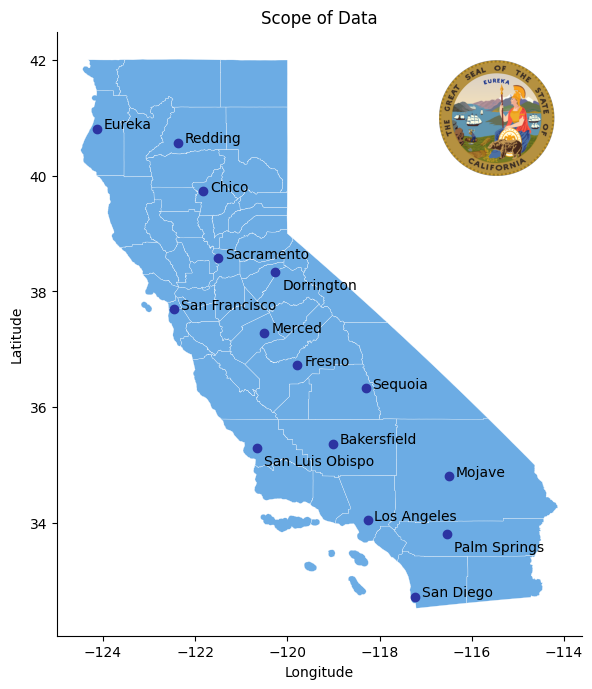

In [ ]:
plot_size(8, 8, 100)
fig, ax = plt.subplots()

# Inserting an image of the The Great Seal of California
im = image.imread(f'{data_dir}utils/Cali_Seal.png')
ax.imshow(im, extent=(-116.7, -114.2, 40, 42))  # Manual position

# Reading a shapefile of California into a geodataframe
raster_file = f'{data_dir}geospatial/CA_Counties_TIGER2016.shp'
gdf_cali = gpd.read_file(raster_file)
# Explicitly the coordinate system (otherwise scale will be off)
coord_str = '+proj=longlat +datum=WGS84 +no_defs'
crs = rasterio.crs.CRS.from_string(coord_str)
gdf_cali = gdf_cali.to_crs(crs=crs)

gdf_cali.plot(ax=ax,
              cmap=cmap,
              linewidth=0.2,
              edgecolor='white')

# Plotting the locations
overlap = ['San Luis Obispo', 'Dorrington', 'Palm Springs']
for key, val in locs.items():
    ax.scatter(val[0], val[1], c=colors['Blue'])
    # Prevent text overlapping
    v_offset = -0.3 if any([key==lap for lap in overlap]) else 0
    ax.text(val[0] + 0.15, val[1] + v_offset, key)

ax.set_title('Scope of Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

As this map reveals, we took care to try and choose locations spread throughout the state, especially choosing locations close to major municipalities (e.g. LA & San Francisco) and/or at optimal locations for solar production due to presumably favourable irradiance (e.g. Mojave, Sequoia). 

**b) Why it is necessary to apply statistical analysis to the dataset?**

Our goal is to model future behavior, namely the solar irradiance in the California for the short and long term. Without proper statistical analysis, or without statistical analysis at all, the use of solar panels may be misguided. Towns and regions should know how much irradiance they could expect, within a reasonable margin, so they are able to anticipate how much energy will be produced from their solar panels and compensate with any lack of supply by different means. This is only possible with the analysis and modeling of the data.

**c) How could humanity benefit from a better model/forecast of your dataset?**

As mentioned in the previous problem, a proper model/forecast of the dataset provides municipalities and regions with a reasonable estimate of how much energy they could anticipate from solar panels that they have set-up or will set-up. This allows them to plan accordingly to fill needs, should they need to compensate with other forms of energy. This can minimize the use of fossil fuels by allowing these local governments to accurately predict how many solar panels they will need and make the proper investments.

# 2. Temporal Trend Analysis


We utilize the powerful `Seaborn` package to create concise plots, revealing key temporal features.

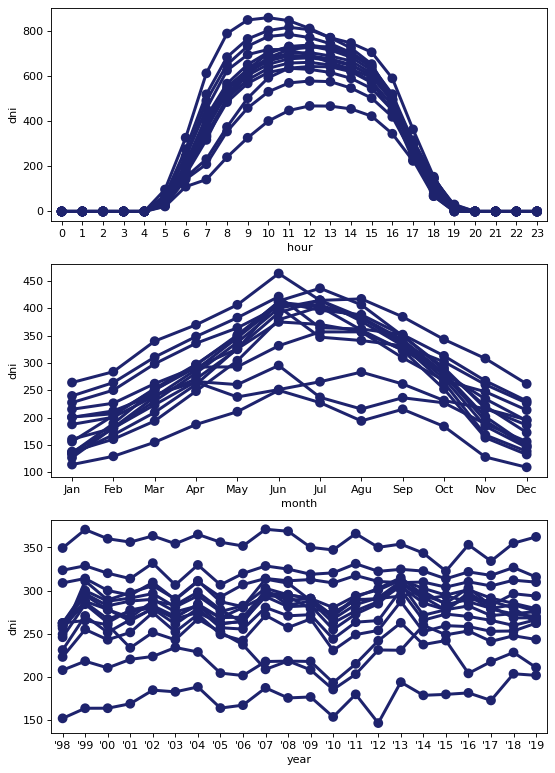

In [ ]:
import temporal

temporal = Temporal()
for key in locs.keys():
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    temporal.plot(df, c=colors['BLUE'])

These three plots have one curve for each location.


**a) Summarize seasonality and annual behavior of your dataset.**

The first graph outlines the average solar irradiance per hour (averaged across all 21 years) compared to the time of the day. As anticipated, we see no solar irradiance during the night (from around 20:00 to 4:00) along with a fast rise starting at 5, plateau/steady decline at 12:00, and a bigger decline starting at 16:00. This corresponds with the angle of the sun above the Earth and is not particularly noteworthy. The only interested feature is that we notice that some of these curves are skewed a little to the left or right. We believe several factors may attribute to this including geographical features of the area (e.g. mountains/valleys, bodies of water, etc.) and the difference in time vs location of the sun (while they are in the same timezone, the sun is actually at a different angle based on the longitude).

The second graph outlines the average solar irradiance per month (averaged each month across all 21 years) compared to the month. We see a linear increase from December to June/July, followed by a steady decrease from June/July to December. This coincides with the angle of the sun's ray's hitting California during the year, more directly (closer to 90 degrees) in the summer and less directly during the winter. There is a notable difference in peaks, some occuring in June and others in July, that we attirbute to the same phenomena that we mentioned earlier (geographical features, timezone).

The third graph outlines the change in average solar irradiance per year (365 day average for each year) compared to the year. We see no trend here, likely due to the very limited scope of the data. It is resonable to note see a significant change in solar irradiance during a 21-year period as there would be no significant changes in the environment during this time. Any change is likely mostly due to noise.

**b) What do your results tell you about the underlying environmental phenomenon?**

The first graph is consistent with the sun's change in angle, or presence, throughout the day. As it approaches noon, the sun will be at its "highest" point, or the closest to 90 degrees relative to the location. This means the rays will hit the ground (or solar panels) more directly and this means more irradiance. This certainly outlines the general trend though there are more factors that can influence it. For example, cities located in valleys may be more sheltered from the sun than cities on mountains, causing a skewed solar irradiance. These differences are not enough to completely change the trend - as shown in our data.

The second graph shows the environmental phenomenon of the Earth's rotation around the sun. During winter months the Sun is less directly hitting the northern hemisphere, so the solar irradiance is subsequently lower. The opposite is true for the summer months. This trend is outlined in our data.

The third graph shows that the previously mentioned phenomena do not vary greatly across the span of 20 years. This is likely due to the buffers, cycles, and capacities (thermal or otherwise) of the Earth.

There are two particularly anomalous curves. Recreating the plots with those two anomalies highlighted reveals the following.

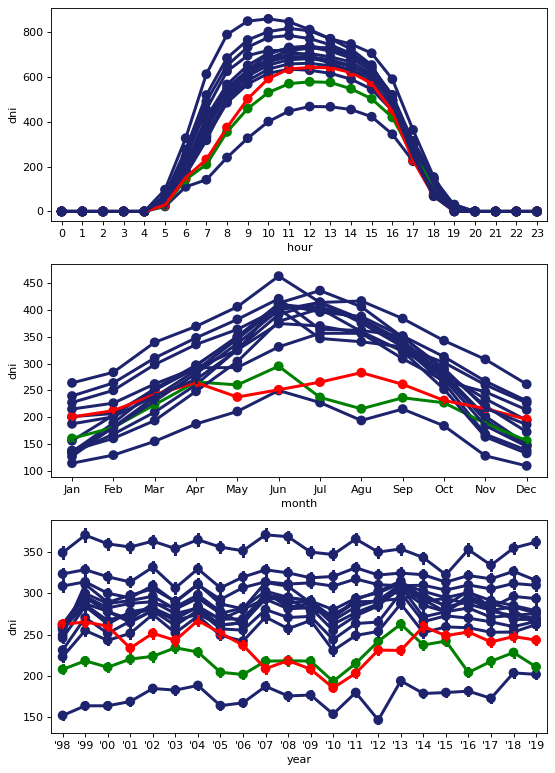

In [ ]:
temporal = Temporal()
for key in locs.keys():
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')

    if key == 'San Francisco':
        c = 'g'
    elif key == 'San Diego':
        c = 'r'
    else:
        c = colors['BLUE']
        
    temporal.plot(df, c=c)

Intuitively, `DNI` should be inversely proportional to latitude. However, looking at the figure we see that <font color='red'>San Diego</font> and <font color='green'>San Francisco</font> seem to debunk this hypothesis. We will try and explain the causality of this in the latter part of the Location Correlation Analysis.

# 3. Location Correlation Analysis

### Mathematical Background

Linear correlation describes the strength of the linear dependency between two variables. It is described in terms of a linear correlation coefficient $R$, which ranges from $-1$ to $1$. Loosely speaking, $R=-1$ describes perfect inverse linear dependency, $R=0$ no linear dependency and $R=1$ perfect proportional linear dependency.

More formally, we define R for two variables x and y as
$$
R = \frac{\sum (x_i  - \bar{x})(y_i-\bar{y})}{\sqrt{\sum (x_i  - \bar{x})^2}\sqrt{\sum (y_i  - \bar{y})^2}}
$$
where $\bar{x}$ denotes mean value (James et al. 2013).

Now, if our data is normally distributed it should be homoscedastic, i.e. a sequence of with should have a constant variance. If however, the variance is different across the elements of the sequence, we say that the vector is heteroscedastic. Visually, this is seen by the scatter points from the sequence diverging (or converging) around the linear regression line (James et al. 2013). We will demonstrate both homo- and heteroscedasticity with an example from our data later on in this section.


**a) How correlated are different measurement sites with each other?**

We start by creating a simple correlation matrix, with a linear correlation for `DNI` values for each location, averaged over each day over the entire 22 years for computational efficiency and noise reduction.

Text(0.5, 1.0, 'Correlation Matrix')

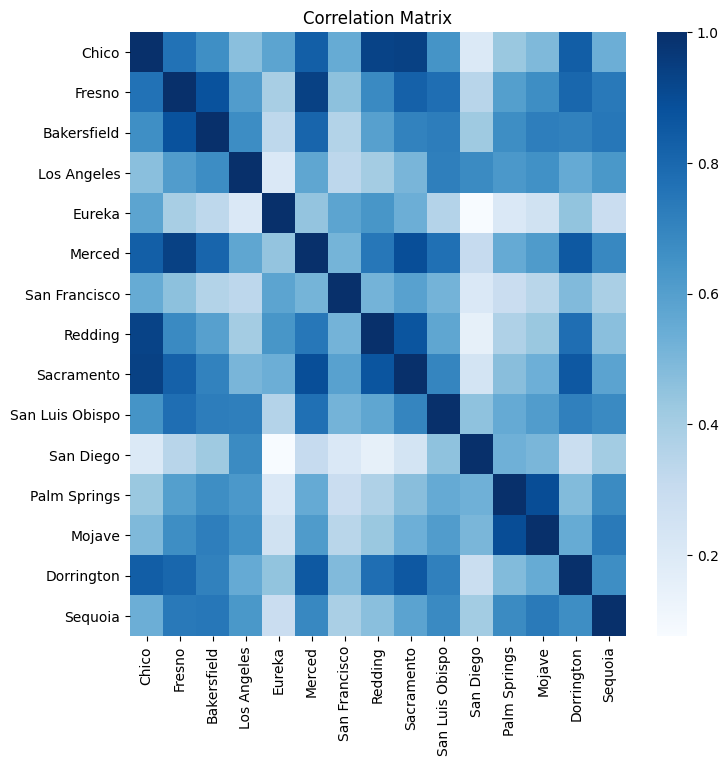

In [ ]:
# Create a df with mean values for each month for each year for each location
df_summed = pd.DataFrame()
indices = [0, 1, 2, 3, 4, 6]
plot_size(8, 8, 100)
for i, key in enumerate(locs.keys()):
    df = pd.read_csv(f'{data_dir}processed/{key}.zip',
                     usecols=indices)
    df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
    df.drop(df.columns[0:5], axis=1, inplace=True)
    df = df.groupby(df['datetime'].dt.to_period('D')).mean()
    df_summed[key] = df.dni

# Create the correlation matrix
df_corr = df_summed.corr()
sns.heatmap(df_corr,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.index,
            cmap='Blues')
plt.title('Correlation Matrix')

**b) How does the correlation change with distance?**

First we calculate the distance between every location and display in a matrix. We measure the distance between two points on the surface of a sphere. We will be calculating both the L-2 and L-1 (Manhattan) distance, we will explain why later on.

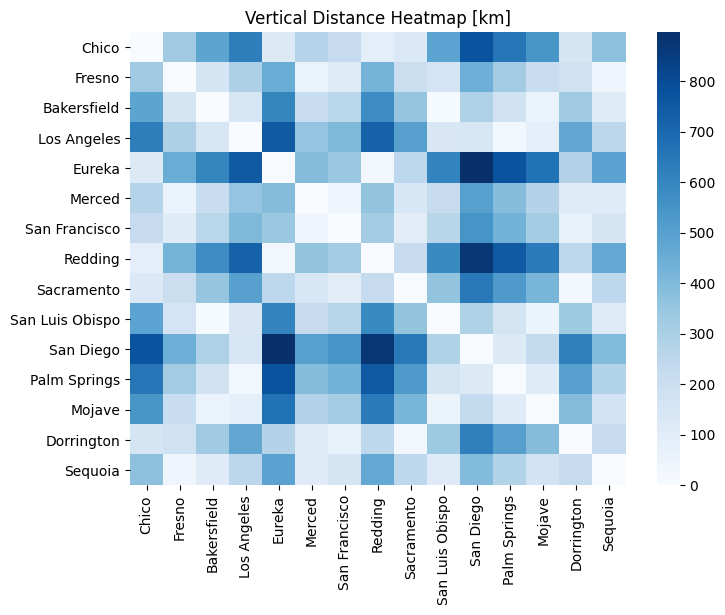

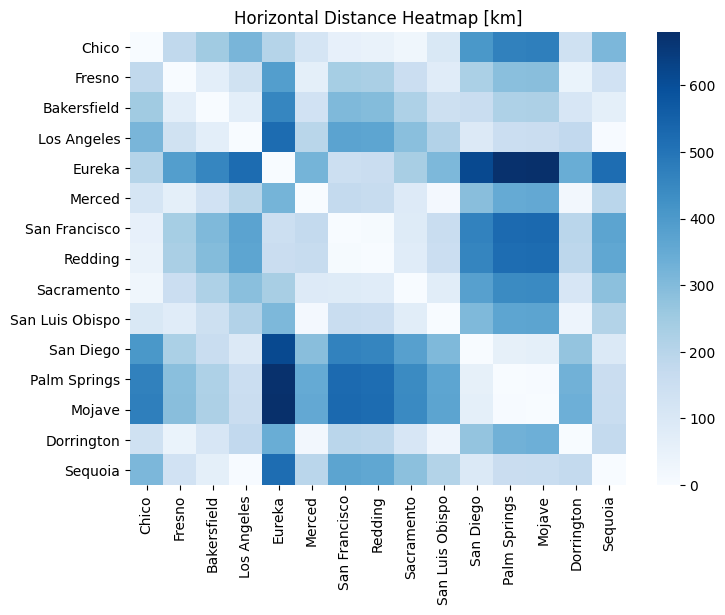

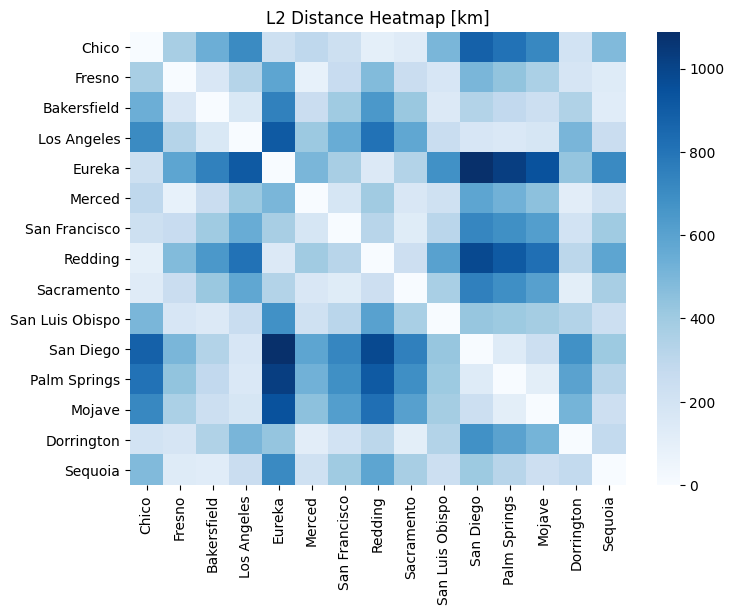

In [ ]:
import distance

dist_vert = dist_vert.df
dist_hori = dist_hori.df
dist_L2 = dist_L2.df

plot_size(8, 6, 100)
fig1, ax1 = plt.subplots()
ax1.set_title('Vertical Distance Heatmap [km]')
sns.heatmap(dist_vert,
            xticklabels=dist_vert.columns,
            yticklabels=dist_vert.index,
            ax=ax1,
            cmap='Blues')
fig2, ax2 = plt.subplots()
ax2.set_title('Horizontal Distance Heatmap [km]')
sns.heatmap(dist_hori,
            xticklabels=dist_hori.columns,
            yticklabels=dist_hori.index,
            ax=ax2,
            cmap='Blues')
fig3, ax3 = plt.subplots()
ax3.set_title('L2 Distance Heatmap [km]')
sns.heatmap(dist_L2,
            xticklabels=dist_L2.columns,
            yticklabels=dist_L2.index,
            ax=ax3,
            cmap='Blues')


We now plot the correlation as a function of distance

Text(0.5, 1.0, 'Distance Correlation')

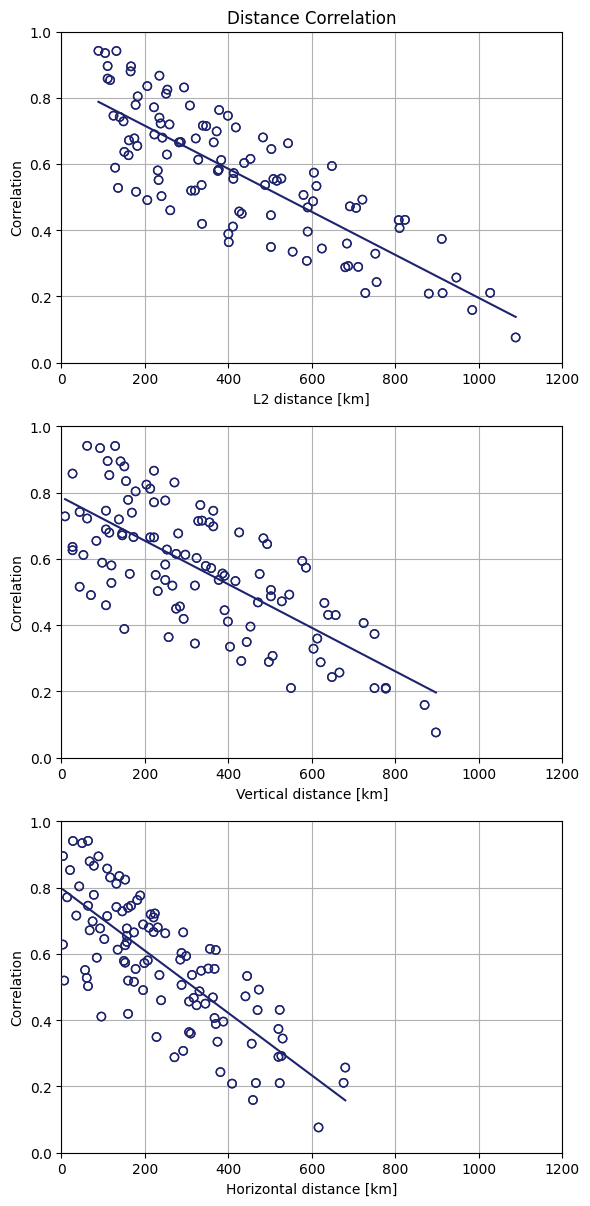

In [ ]:
plot_size(6, 12, 100)
fig, (ax1, ax2, ax3) = plt.subplots(3)
N = len(locs)
seaside = ['Los Angeles', 'Eureka', 'San Diego',
           'San Francisco', 'San Luis Obispo']


dc_L2 = DistCorr(dist_L2, ax1, 'L2')
dc_vert = DistCorr(dist_vert, ax2, 'Vertical')
dc_hori = DistCorr(dist_hori, ax3, 'Horizontal')

for i in range(N):
    for j in range(N):
        if i != j: # We don't plot the diagonal values
            dc_L2.corr_dist(i, j)
            dc_vert.corr_dist(i, j)
            dc_hori.corr_dist(i, j)

dc_L2.lin_regr()
dc_vert.lin_regr()
dc_hori.lin_regr()
xy_L2 = dc_L2.get_xy()
xy_vert = dc_vert.get_xy()
xy_hori = dc_hori.get_xy()

plt.tight_layout()
ax1.set_title('Distance Correlation')

The relationship for both methods looks reasonably linear. The L-2 and vertical distance correlations looks heteroscedastic, whereas the horizontal distance seems homoscedastic. We hypothesize that the heteroscedasticity is because of the different irradiance patterns for seaside locations, and the homoscedasicity because longitude isn't a predictor for `DNI`.

Let's look at whether the distribution of <font color='green'>seaside-inland</font> and <font color='red'>seaside-seaside</font> correlation pairs are different from <font color='blue'>inland-inland</font> correlation pairs.

Text(0.5, 1.0, 'Distance Correlation')

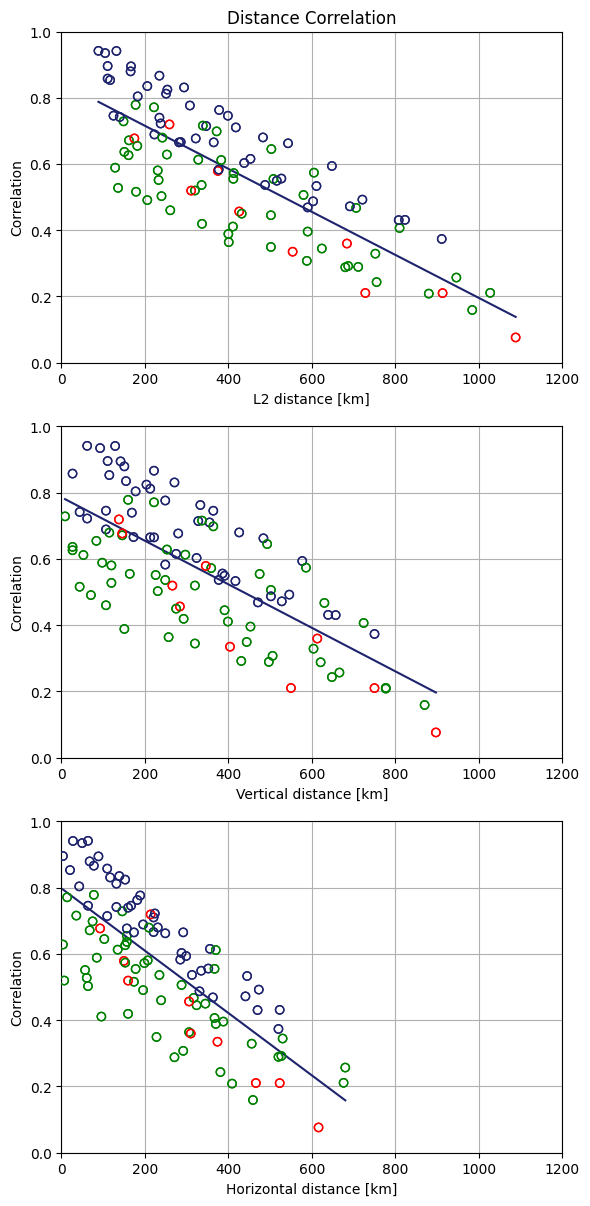

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

dc_L2 = DistCorr(dist_L2, ax1, 'L2', False)
dc_vert = DistCorr(dist_vert, ax2, 'Vertical', False)
dc_hori = DistCorr(dist_hori, ax3, 'Horizontal', False)

for i in range(N):
    for j in range(N):
        if i != j: # We don't plot the diagonal values
            dc_L2.corr_dist(i, j)
            dc_vert.corr_dist(i, j)
            dc_hori.corr_dist(i, j)

dc_L2.lin_regr()
dc_vert.lin_regr()
dc_hori.lin_regr()

plt.tight_layout()
ax1.set_title('Distance Correlation')

The figure reveals that the <font color='green'>seaside-inland</font> and <font color='red'>seaside-seaside</font> are less linearly correlated than <font color='blue'>inland-inland</font> correlation pairs, corroborating our hypothesis.


Let's create a linear model to properly quantify the relationship between correlation and distance. This is where R admittedly reigns superior to Python in terms of simplicity, so we're basically going to recreate the R diagnosic plots. The next cell's code is adapted and modified from [here](https://bit.ly/3231wrB).

                            OLS Regression Results                            
Dep. Variable:            correlation   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     397.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           4.09e-50
Time:                        06:15:48   Log-Likelihood:                 158.87
No. Observations:                 210   AIC:                            -313.7
Df Residuals:                     208   BIC:                            -307.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8455      0.016     53.257      0.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


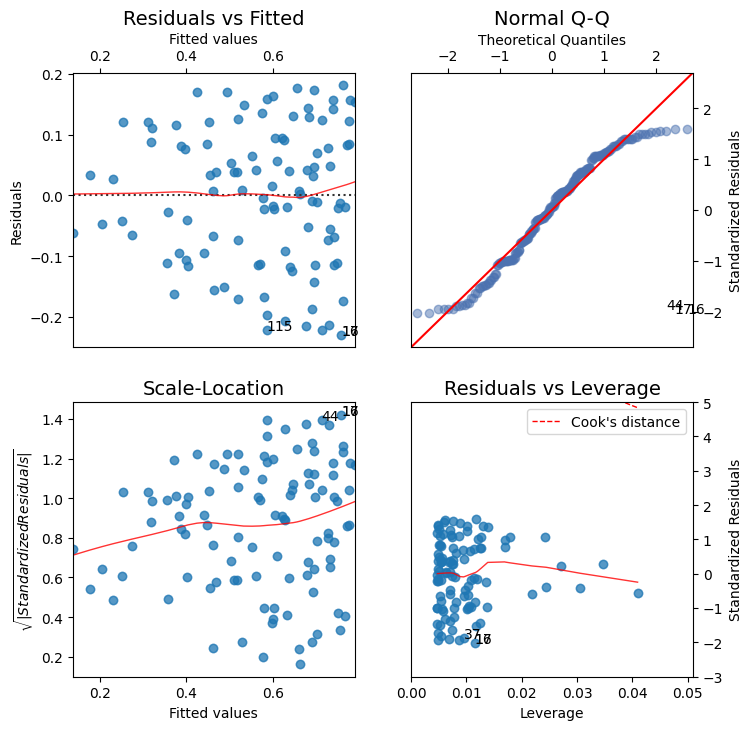

In [ ]:
plot_size(8, 8, 100)

import diagnostics   
    
DiagnosticPlots(xy_L2.distance, xy_L2.correlation)

The four diagnostic plots indicate the following:

- *Residuals vs. Fitted* demonstrates a relatively linear relationship, as the red line is pretty horizontal

- The *QQ-plot* behaves nicely around the middle, but deviates from a straight line at the ends, indicating imperfect normal distribution

- The heteroscedasticity we've hinted at is finally corroborated in the *Scale-Location* plot (and the Residuals vs. Fitted)

- From *Residuals vs. Leverage* we infer that no outliers are negatively affecting our model.

Following our earlier revelation that distance to sea seems to be a factor in modeling `DNI`, we are now going to look at their relationship with latitude.

We start by plotting location as a function of `DNI`.

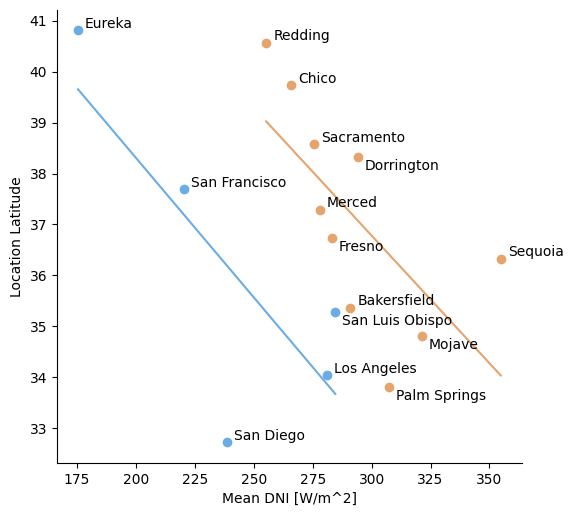

In [ ]:
def lin_regr(x, y, c):
    p = np.polyfit(x, y, deg=1)
    x_r = np.linspace(min(x), max(x))
    y_r = np.polyval(p, x_r)
    ax.plot(x_r, y_r, c=c)

plot_size(6, 6, 100)
fig, ax = plt.subplots()
df_lat = pd.DataFrame(np.zeros((len(locs), 4)),
                    columns=['lat', 'dni', 'loc', 'sea'])
seaside = ['Los Angeles', 'Eureka', 'San Diego',
           'San Francisco', 'San Luis Obispo']
lowers = ['Dorrington', 'Fresno', 'San Luis Obispo', 'Mojave', 'Palm Springs']
for i, (key, val) in enumerate(locs.items()):
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    df_lat.iloc[i, 0] = val[1]  # val[1] is latitude
    df_lat.iloc[i, 1] = df.dni.mean()
    df_lat.iloc[i, 2] = key  # key is name of location
    df_lat.iloc[i, 3] = True if any([key==sea for sea in seaside]) else False

    c = colors['blue'] if df_lat.sea[i] else colors['orange']
    ax.scatter(df_lat.dni[i], df_lat.lat[i], c=c)
    # Prevent overlapping
    v_offset = -0.25 if any(key == lower for lower in lowers) else 0.05
    ax.text(df_lat.dni[i] + 3, df_lat.lat[i] + v_offset, key)

df_inland = df_lat[df_lat.sea == False]
df_sea = df_lat[df_lat.sea == True]
lin_regr(df_inland.dni, df_inland.lat, colors['orange'])
lin_regr(df_sea.dni, df_sea.lat, colors['blue'])

ax.set_xlabel('Mean DNI [W/m^2]')
ax.set_ylabel('Location Latitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Ths figure further demonstrates that the five coastal cities (blue) receive less insolation, especially Eureka, San Francisco and San Diego; LA and San Luis Obispo to a lesser extent. The two regression lines are drawn to underline the different behavior of the two classes.

Let's see how well the irradiance follows the equation

$$
I = \beta_2 r + \beta_1 \varphi + \beta_0
$$

where $I$ is `DNI` over the sampling period, $r$ is distance to shore, $\varphi$ is latitude and $\beta_i$ denotes multivariate linear regression coefficients.

First we calculate the distance to shore

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


Text(190.3657028277839, 0.5, 'Latitude')

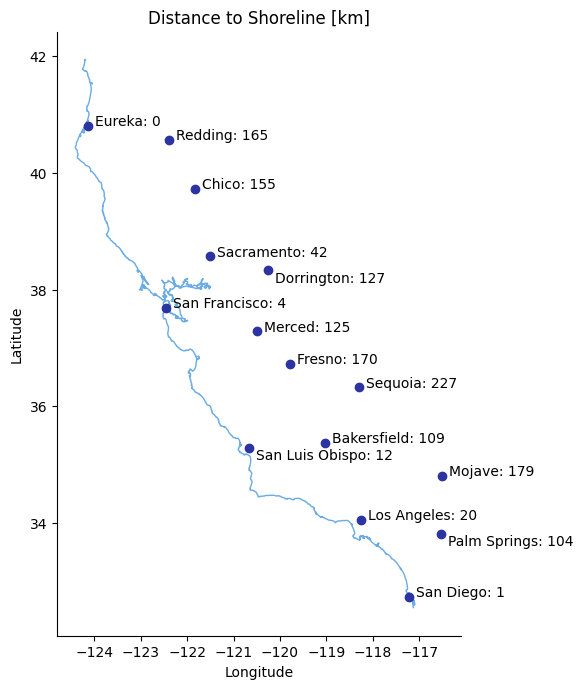

In [ ]:
fig, ax = plt.subplots()

gdf_shore = gpd.read_file(f'{data_dir}geospatial/coastl_usa.shp')
gdf_shore = gdf_shore.to_crs(crs=crs)
gdf_shore.plot(ax=ax, cmap=cmap, linewidth=1, edgecolor='white', zorder=-1)
r = np.zeros(len(locs))
for i, (key, val) in enumerate(locs.items()):
    point = gpd.GeoSeries([Point(val[0],val[1])])
    point.crs = crs
    dist = gdf_shore.distance(point)
    r[i] = round(dist[0] * 100)
    ax.scatter(val[0], val[1], c=colors['Blue'])
    v_offset = -0.2 if any([key==lap for lap in overlap]) else 0
    r_text = np.array2string(r[i])
    r_text = r_text.split(".")[0]
    ax.text(val[0] + 0.15, val[1] + v_offset, f'{key}: {r_text}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Distance to Shoreline [km]')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

There's an inherent problem there. Because our algorithm simply looks for the shortest distance to shoreline, Sacramento and Dorrington are calculated as being way closer to sea than they actually are because of San Francisco Bay. We will be compensating for that manually, as modifying shapefiles is a cumbersome GIS-endeavour. 

Now let's perform multivariate Linear Regression

In [ ]:
regr = sklearn.linear_model.LinearRegression()
df_lat['r'] = r

# Manually changing approximate correct values for Sacramento
# and Dorrington
df_lat.iloc[8, -1] = 100
df_lat.iloc[13, -1] = 220

regr.fit(df_lat[['lat', 'r']], df_lat.dni)
B0 = regr.intercept_
B1, B2 = regr.coef_
I = B2 * df_lat.r + B1 * df_lat.lat + B0

Let's plot the regression results to get a qualitative feel for it

Text(0.5, 1.0, 'DNI vs. Lat & Distance to Sea [km]')

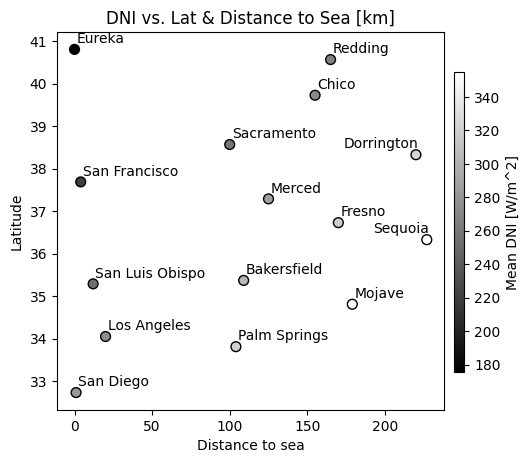

In [ ]:
plot_size(5, 5, 100)
fig, ax = plt.subplots()
ax.scatter(df_lat.r, df_lat.lat, c=I, cmap='gray', edgecolor='k', s=50)
ax.set_xlabel('Distance to sea')
ax.set_ylabel('Latitude')
sm = plt.cm.ScalarMappable(cmap='gray',
                           norm=plt.Normalize(vmin=min(df_lat.dni),
                                              vmax=max(df_lat.dni)))
ax2 = fig.add_axes([0.92, 0.20, 0.02, 0.6])
fig.colorbar(sm, cax=ax2, orientation='vertical', label='Mean DNI [W/m^2]')
move = ['Dorrington', 'Sequoia']
for i in range(len(df_lat)):
    ha = 'right' if any(df_lat.loc[i,'loc'] == m for m in move) else 'left'
    ax.text(df_lat.loc[i, 'r'] + 1.5,
            df_lat.loc[i, 'lat'] + 0.15,
            df_lat.loc[i, 'loc'],
            ha=ha)
ax.set_aspect('auto')
ax.set_title('DNI vs. Lat & Distance to Sea [km]')

It seems as if these two variables do a good job of modeling mean DNI, but we need to have a quantitative look at the model results.

In [ ]:
model = sm.OLS(df_lat.dni, df_lat[['lat']]).fit()
print('SINGLE VARIABLE - LAT')
print(model.summary())

SINGLE VARIABLE - LAT
                                 OLS Regression Results                                
Dep. Variable:                    dni   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              396.5
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                    1.14e-11
Time:                        17:03:51   Log-Likelihood:                         -80.367
No. Observations:                  15   AIC:                                      162.7
Df Residuals:                      14   BIC:                                      163.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [ ]:
model = sm.OLS(df_lat.dni, df_lat[['lat', 'r']]).fit()
print('TWO VARIABLES - LAT & DISTANCE TO SEA')
print(model.summary())

TWO VARIABLES - LAT & DISTANCE TO SEA
                                 OLS Regression Results                                
Dep. Variable:                    dni   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              260.1
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                    3.28e-11
Time:                        17:03:55   Log-Likelihood:                         -77.850
No. Observations:                  15   AIC:                                      159.7
Df Residuals:                      13   BIC:                                      161.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


We see that the F-statistic for the latitude-only model is 396.5, higher than
the bivariate model's F-statistic of 260. The trend follows for the AIC values. Though the adjusted R-squared values are similar for both at .97,
we see that the additional variable does not help our model. That doesn't necessarily reject our hypothesis, as it only means that seaside proximity doesn't improve the model, not that there isn't any causality (James et al. 2013).

## 4. Long-Term Forecast

**Establish a forecast model and predict the future trend of your dataset across different locs. You should use 2/3 of the time duration in your data set to train your model, and test the result using the rest 1/3 dataset.**

We will begin the long-term forecast model by plotting a correlation matrix of the variables. This is meant to show us the relationship between one variable to another and therefore give us information on potential collinearity in our overall model. 

Each graph is its own simple linear regression. It is formed be the Ordinary Least Squares method which takes a compilation of the function

More formally, we define R for two variables x and y as

$$
y_i = \beta_0+\beta_1\sum(x_i)+ϵi,   i=1,2...n
$$

and uses n examples of it to form the following:

$$
\sum(y_i)=n\beta_0+\beta_1∑x_i+∑ϵ_i
$$
To minimize the sum of the squared rediduals we use 

$$
C=(\beta_0+\beta_1x_1−y_1)^2+(\beta_0+\beta_1x_2−y_2)^2+...+(\beta_0+\beta_1x_n−y_n)^2
$$

where we minimize C by taking partial derivatives with respect to B1 and set the results to 0 to get 

$$
∑x_iy_i=∑x_i\beta_0+\beta_1∑x^2_i 
$$

Solving for β0 and β1 we now get:

$$
\beta_0=\frac{((∑x^2_i)(∑y_i)−(∑x_i)(∑x_iy_i))}{n∑x^2_i−(∑x_i)^2}
$$

$$
\beta_1= \frac{(n(∑x_iy_i)−(∑x_i)(∑y_i))}{n∑x_i^2−(∑x_i)^2}
$$

This method iterated over multiple variables allows us to see the lines in the correlation matrix seen below.

Across the diagnoal we see kernel density estimations which are a non-parametric way of estamating the probability densit function of a random variable.

If we take an independent and identicaly distributed sample, we can greate a density function f with the following formula:

$$
f^n(x)=\frac{1}{nh}\sum_{i=1}^{n}K(\frac{X_i−x}{h})
$$

where h is the bandwidth, K is the kernal function, the integration of this formula is 1, and it is distributed around x=0

After our simple linear regression, we then use a multivariate linear regression to see the correlation between many dependent variables and our independent variable, DNI. 

We begin with:

$$
y_i = \beta_0v+ \beta_1x_{i1}+\beta_2x_{i2}+...+\beta_px_{ip}+\epsilon_i
$$

$$
Y = X\beta + \epsilon
$$

Where Y is a vector n*1 which is the predicted vector

X is a matrix n*(p+1) which is a predictor matrix

β is a vector (p+1)*1 which is a parameter or coefficient vector

ϵ is a vector n*1 which is a residual or error vector

The coefficients for each variable are expressed below and we see several factors with low coefficients, so they have low impact on the model. We also weeded out any variables with high p-values as they are not good fits for the data.

The t-value for any score is calculated with the following equation: 

$$
t = \frac{\hat{\beta_1}-0}{SE(\hat{\beta_1})}
$$

and allows the hypothesis to be rejected, should the corresponding p-value be less than 5%, for this instance.



                         Coeff
month                -3.150435
cloud type          -36.698987
dew point            11.623154
solar zenith angle   -1.447857
fill flag            -2.466304
surface albedo      501.372563
wind speed           -3.252816
precipitable water  -28.024000
wind direction        0.097866
relative humidity    -5.207893
temperature          -7.663670
pressure             -0.225947
Mean Absolute Error: 42.6
Mean Squared Error: 3289
Sqrt of MSE: 57.4
                                 OLS Regression Results                                
Dep. Variable:                    dni   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.175e+04
Date:                Fri, 16 Apr 2021   Prob (F-statistic):                        0.00
Time:                        14:28:10   Log-Likelihood:                         -29511.


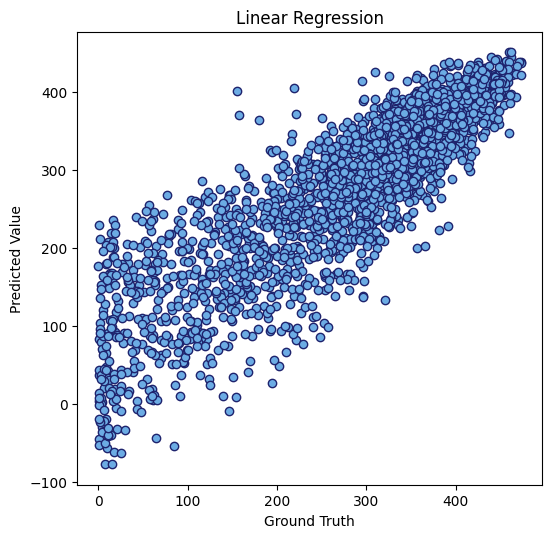

In [ ]:
loc = 'Los Angeles'
df = pd.read_csv(f'{data_dir}processed/{loc}.zip')
df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
df = df.groupby(df['datetime'].dt.to_period('d')).mean()
y = df['dni']
dropping = ['year', 'day', 'hour', 'minute', 'dhi', 'dni',
            'ghi', 'clearsky dhi', 'clearsky dni',
            'clearsky ghi', 'global horizontal uv irradiance (280-400nm)',
            'global horizontal uv irradiance (295-385nm)']
x = df.drop(dropping, axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(pd.DataFrame(model.coef_, x.columns, columns=['Coeff']))

plot_size(6, 6, 100)
plt.scatter(y_test, y_pred,
            edgecolors=colors['BLUE'], facecolors=colors['blue'])
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Value")
plt.title("Linear Regression")

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
sqrt_mse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {round(mae, 1)}')
print(f'Mean Squared Error: {round(mse)}')
print(f'Sqrt of MSE: {round(sqrt_mse, 1)}')

OLS_model = sm.OLS(y_train, x_train).fit()
print(OLS_model.summary())

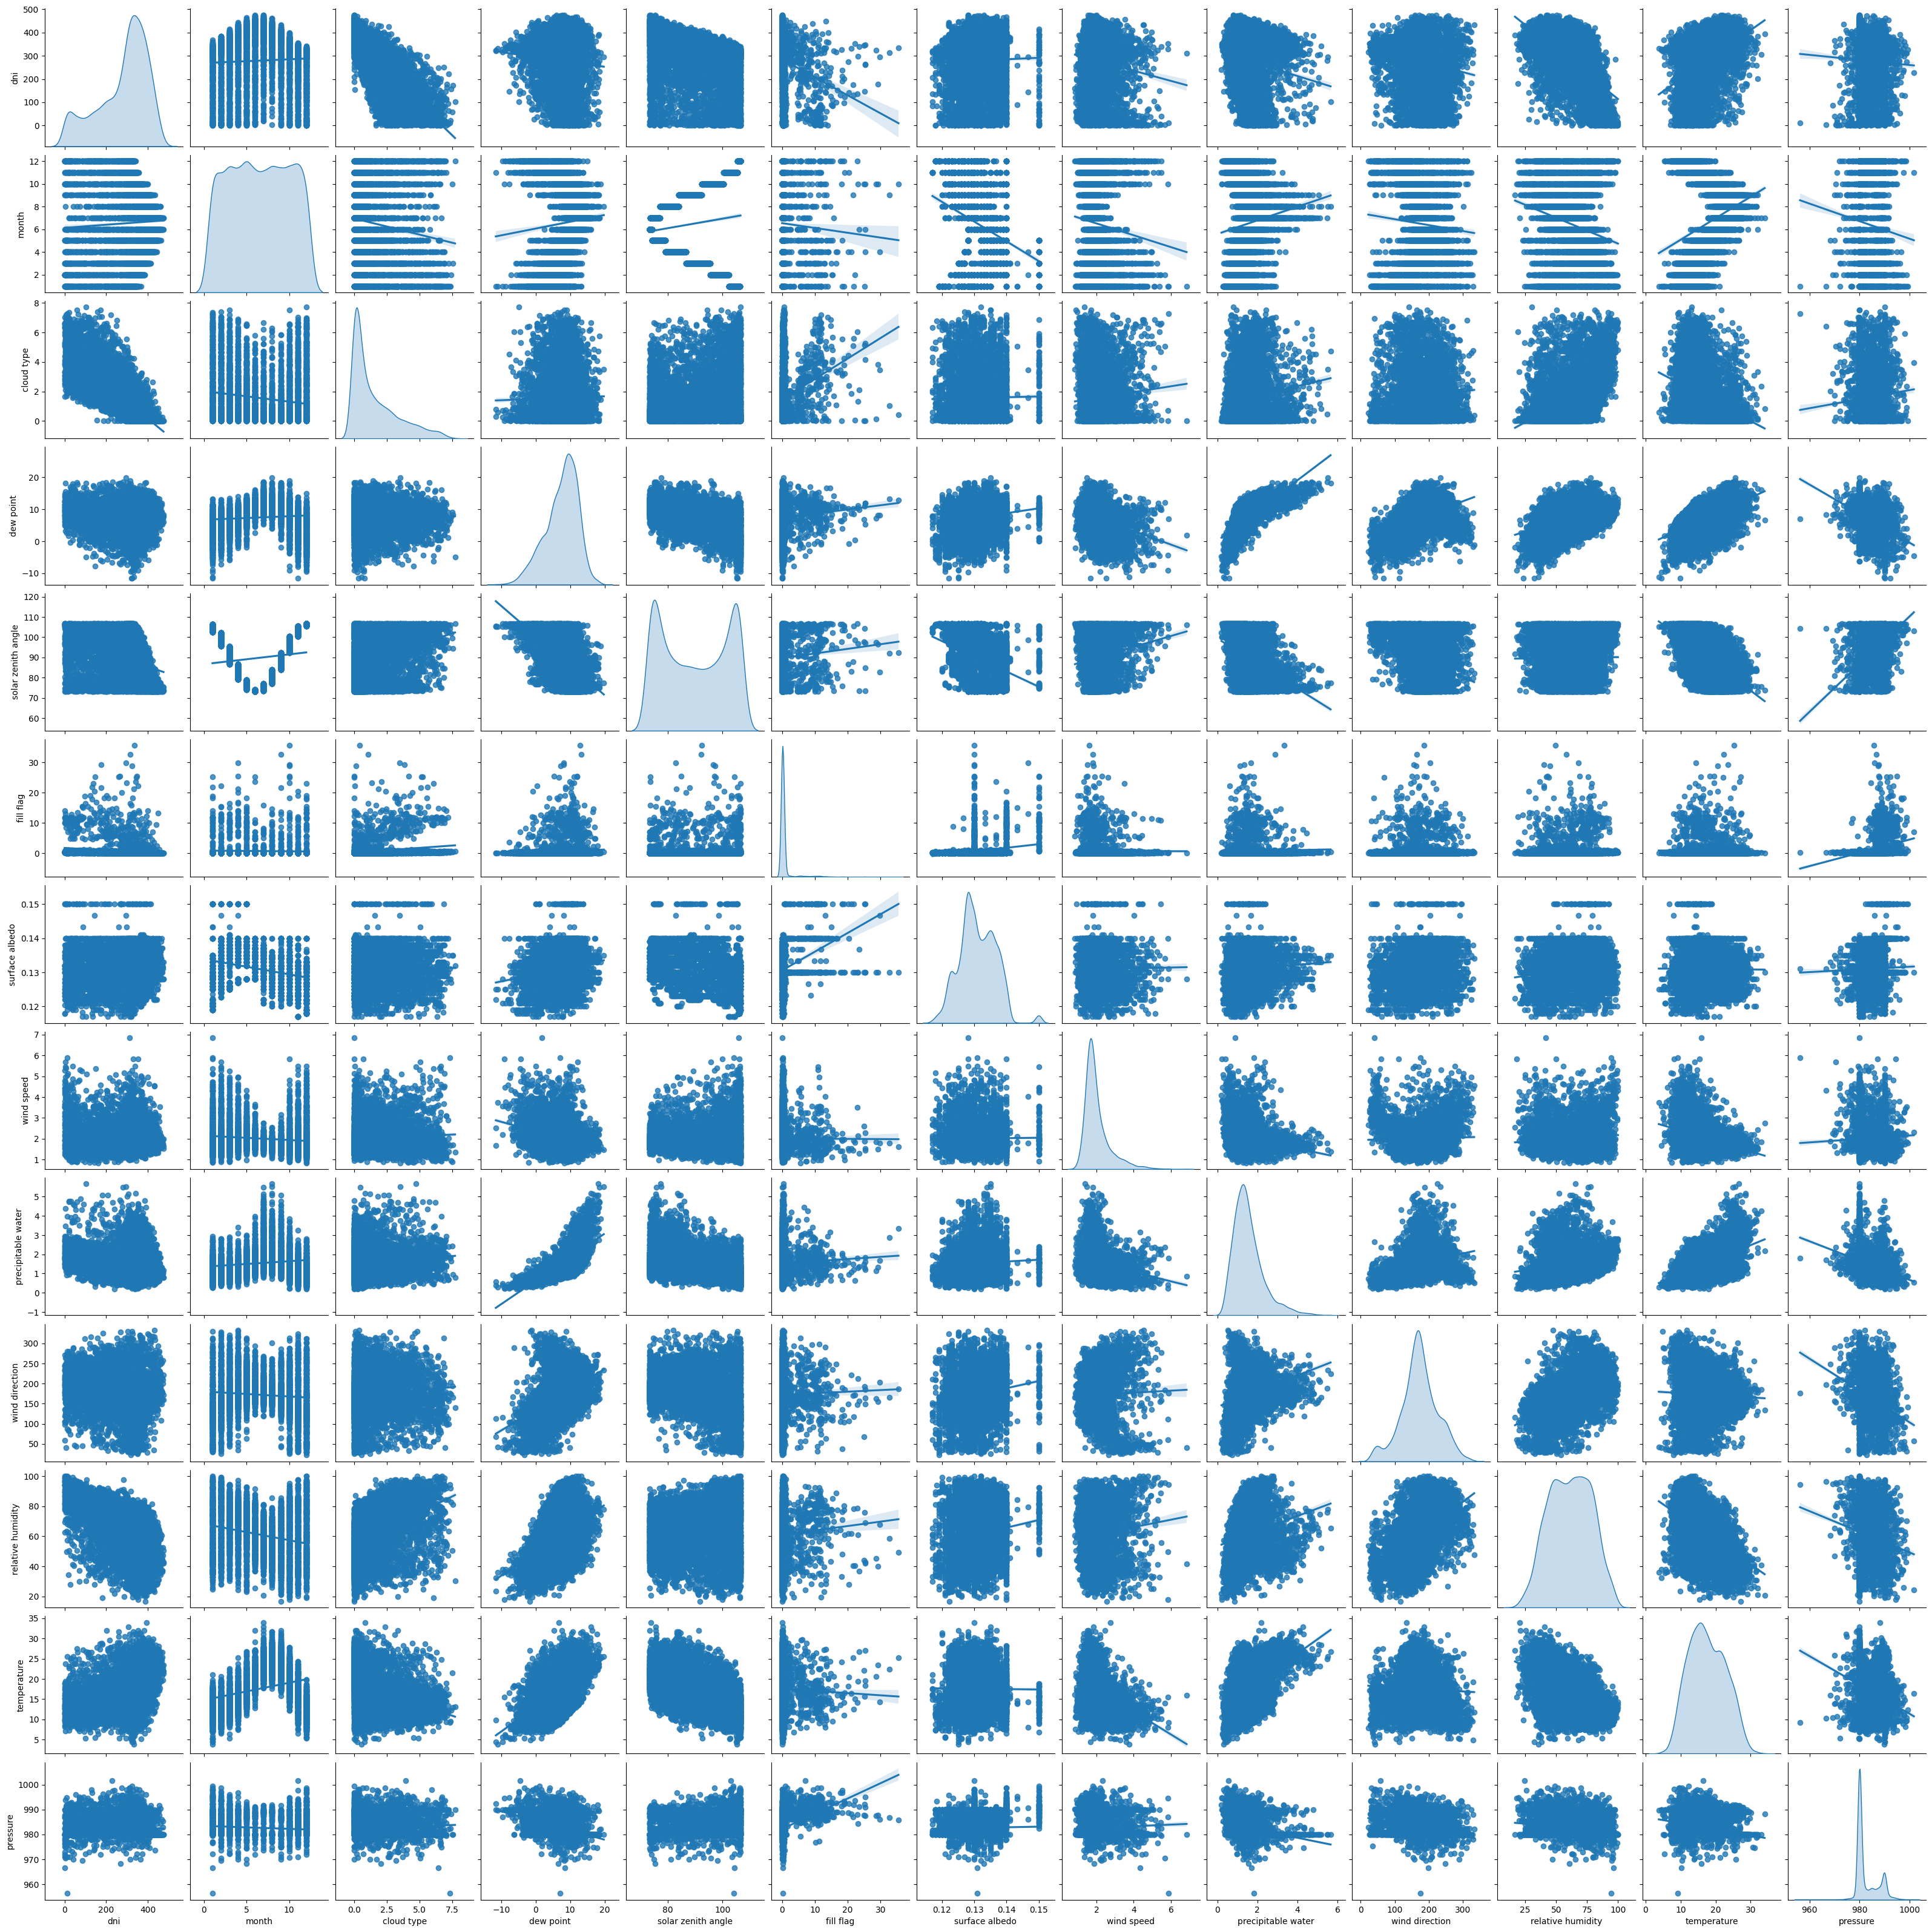

In [ ]:
train_dataset = x_train.copy()
train_dataset.insert(0, "dni", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

Model score: 0.765811660761305


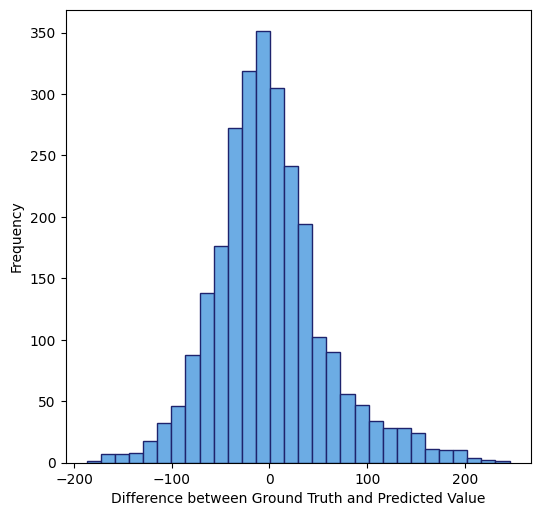

In [ ]:
plt.hist(y_pred - y_test, bins=30, color=colors['blue'], ec=colors['BLUE'])
plt.ylabel("Frequency")
plt.xlabel("Difference between Ground Truth and Predicted Value")
print(f'Model score: {model.score(x_test, y_test)}')

The two graphs we see above include a graph of predicted value vs true value and the distribution of the frequency of the difference between true value and predicted value.

The predicted values are calculated based on the inputs in our test data along with the equation of our multiple linear regression line. The ground truth is already contained in our test data.

We also use several diagnostic tools to assess the fit of our model. This includes the mean absolute error (MAE), the mean squared error (MSE), the root mean squared error (RMSE), and the accuracy of our model.

The mean absolute error is calculated by dividing the difference between predicted and true values (SAE) by the number of samples or:

$$
\sum^{n}_{i=1}|x_i-x_t|
$$

This would then be divided by n

The MSE is calculated by squaring the difference of the predicted value and the observed value, and dividing by n. This penalizes any big errors in the data:

$$
MSE = \sum\frac{(P_i-O_i)^2}{n}
$$


The RMSE is then just the square root of these values. Its equation is as follows:

$$
RMSE = \sqrt{\sum\frac{(P_i-O_i)^2}{n}}
$$

Finally, the accuracy of our model is computed through the following equation:

$$
Accuracy = 1 - \frac{|Predicted - Observed|}{Observed}
$$

This tells us how closely our data comes within our prediction.

LassoCV(alphas=[1, 1.05, 1.15, 1.2, 1.25], copy_X=True, cv=5, eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)
Alpha: 1.15
R2: 1
MSE: 3296.8
RMSE: 57.4
Mean Absolute Error: 42.9


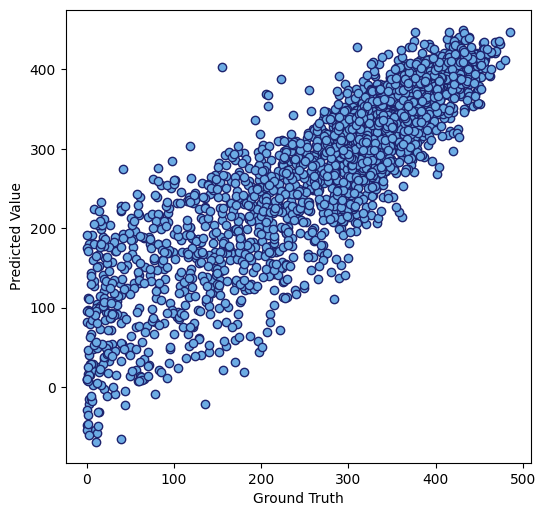

In [ ]:
# Lasso Regression
alphas = [1, 1.05, 1.15, 1.2, 1.25]
lassocv = LassoCV(alphas=alphas, cv=5).fit(x,y)
print(lassocv)
LassoCV(alphas=[0.1, 0.3, 0.5, 0.8, 1], copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False) 

score = lassocv.score(x,y)
y_pred = lassocv.predict(x_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'Alpha: {round(lassocv.alpha_,2)}')
print(f'R2: {round(score)}')
print(f'MSE: {round(mse, 1)}')
print(f'RMSE: {round(np.sqrt(mse), 1)}')

plot_size(6, 6, 100)
plt.scatter(y_test, y_pred,
            facecolors=colors['blue'], edgecolors=colors['BLUE'])
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Value")
mae = round(metrics.mean_absolute_error(y_test, y_pred), 1)
print(f'Mean Absolute Error: {mae}')

For this model, we begin with a Lasso which is a method used to fit a regression model when we know that multicollinearity is present in our data, which we saw in our earlier table. It tries to find coefficient estimates that minimize the sum of squared residuals, defined by the following equation

$$
RSS = \sum^n_{i=1}(\hat{Y_i}-\bar{Y})
$$

and produce the MSE through optimization of a shrinkage penalty:

$$
RSS + \lambda\sum^p_{j=1}|\beta_j|
$$

After optimizing the amount of predictor variables to minimize the MSE, we calculate our multiple linear regression and test stastic using the same methods we used in our previous example.

In [ ]:
lasso = Lasso(alpha=1.5)

# Fit the Lasso model
lasso.fit(x_train, y_train)
# Create the model score
score = lasso.score(x_test, y_test)
print(f'Score: {round(score, 2)}')

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
sqrt_mse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {round(mae, 1)}')
print(f'Mean Squared Error: {round(mse)}')
print(f'Sqrt of MSE: {round(sqrt_mse, 1)}')

Score: 0.76
Mean Absolute Error: 43.3
Mean Squared Error: 3300
Sqrt of MSE: 57.4


Text(0.5, 0, 'Difference between Ground Truth and Predicted Value')

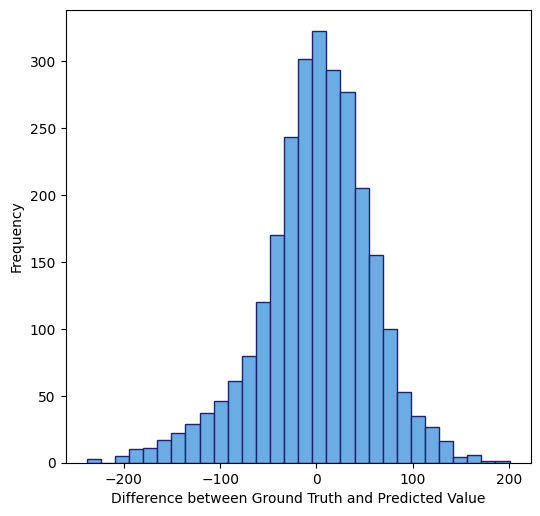

In [ ]:
y_pred = lasso.predict(x_test)
plot_size(6, 6, 100)
plt.hist(y_test - y_pred, bins=30, color=colors['blue'], ec=colors['BLUE'])
plt.ylabel("Frequency")
plt.xlabel("Difference between Ground Truth and Predicted Value")

The next method we will use it Principal Components Analysis (PCA) which is a machine learning technique that finds linear combinations of the original predictor variables to explain a large portion of the variation in the dataset. Its goal is to eliminate collinearity and use fewer variables than the original data set. 

PCA is split into two steps, dimension reduction formulation and maximum variance formulation.

The dimension reduction process proceeds as follows:

$$
z_m=\sum^p_j=1\phi_{jm}X_j
$$

where Z1, Z2,..., ZM represent M<p linear combinations of our original predictors, p. We then fit the linear regression model:

$$
y_i = \theta_0+\sum^M_{m=1}\theta_mz_{im}+\epsilon_i, i =1,...,n
$$

and combining these equations we see

$$
\sum^M_{m=1}\theta_mz_{im}=\sum^M_{m=1}\theta_m\sum^M_{j=1}\phi_{jm}x_{ij}=\sum^p_{j=1}\sum^M_{m=1}\theta_m\phi_{jm}x_{ij}=\sum^p_{j=1}\beta_jx_{ij}
$$

$$
\beta_j = \sum^M_{m=1}\theta_m\phi_{jm}
$$

Next, we find the maximum variance formulation. We start by writing into matrix form:

$$
Z = \phi^TX_n
$$

and maximizing via the following:

$$
\frac{1}{N-1}\sum^N_{n=1}(\phi^TX_n-\phi^T\bar{X})^2=\phi^TS\phi
$$

Mean Absolute Error: 43.7
Mean Squared Error: 3410
Sqrt of MSE: 58.4


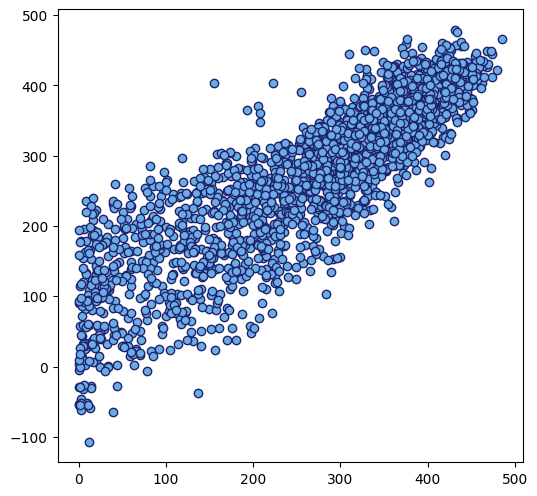

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Make an instance of the Model
pca = PCA(.90)

pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

linearRegr = LinearRegression()

linearRegr.fit(x_train, y_train)
linearRegr.score(x_test, y_test)

y_pred = linearRegr.predict(x_test)
plt.scatter(y_test, y_pred, facecolors=colors['blue'], edgecolors=colors['BLUE'])

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
sqrt_mse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {round(mae, 1)}')
print(f'Mean Squared Error: {round(mse)}')
print(f'Sqrt of MSE: {round(sqrt_mse, 1)}')

Score: 0.76


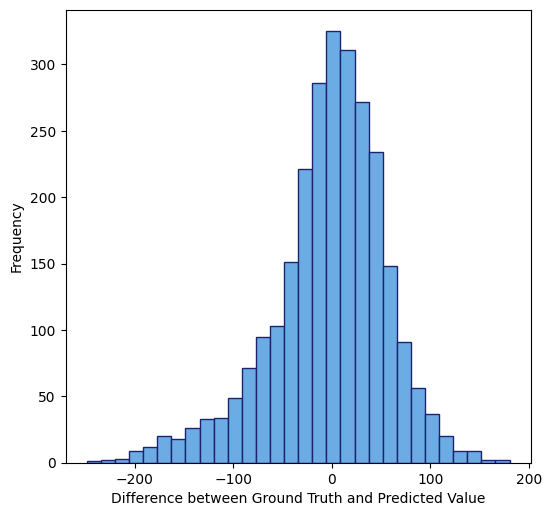

In [ ]:
plt.hist(y_test - y_pred, bins=30, color=colors['blue'], ec=colors['BLUE'])
plt.ylabel("Frequency")
plt.xlabel("Difference between Ground Truth and Predicted Value")
score = linearRegr.score(x_test,y_test)
print(f'Score: {round(score, 2)}')

                           0         1
month              -0.099346 -0.167580
cloud type          0.108970  0.518968
dew point           0.456641 -0.040164
solar zenith angle -0.334683  0.559143
fill flag           0.015219  0.055167
surface albedo      0.182034 -0.038450
wind speed          0.025763  0.189285
precipitable water  0.276071 -0.091807
wind direction      0.998903 -0.034768
relative humidity   0.565820  0.772531
temperature        -0.071029 -0.744218
pressure           -0.320520  0.144461


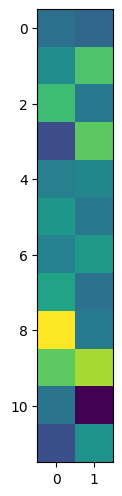

In [ ]:
principalComponents = pca.fit_transform(x)
corr = pca.components_
features = pca.explained_variance_ratio_
matrix = pca.components_.T * np.sqrt(pca.explained_variance_)

pca_cor = pd.DataFrame(data=[[np.corrcoef(x[c],principalComponents[:,n])[1,0] 
               for n in range(pca.n_components_)] for c in x])
pca_cor.set_index(x.columns, inplace=True)
print(pca_cor)

plt.imshow(pca_cor, cmap=None,interpolation=None) 

# 5. Short-Term Forecast


**Establish a forecast model and predict the data value over the next five time steps over all measurement sites. You should test your method
over several representative scenarios each covering, typically, one day of duration. You must
train your forecast model using data before your testing scenario, while you are free to choose
how much data to train your short-term forecast model.**

### Mathematical Background

We will be training a Long-Short-Term-Memory model (LSTM) on each location in our dataset. LSTM models are a type of Recurrent Neural Networks (RNNs), specially designed to handle time series by retaining long-term dependencies.

LSTM models are characterized by four logical gates, see figure, as well as the cell state, the upper horizontal line. It runs from one timestep to the next, allowing information to percolate through the model.

<img src='https://drive.google.com/uc?id=1as8WKjC7gdrX4T_fxGXFxuqYIBbEsQvV'>

(*figure: Olah, 2015*)

Regarding the four gates, the first one is a forget gate layer, activated by a sigmoid function

$$
f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f)
$$ 

where $W_f$ is a matrix containing the model weights, and note that the subscript  $f$ denotes the gate, $h_{t-1}$ is the hidden layer from the previous timestep, $x_t$ is the model input, $b_t$ is the bias, and

$$
\sigma = \frac{1}{1+e^{-y}}
$$

is the sigmoid activation function for variable $y$. This layer tells us whether we should get rid of previous information in the cell state. The second layer tells us which values to update, as such

$$
i_t = \sigma (W_i \cdot [h_{t-1}, x_t] b_i)
$$

The third layer, generates the potential values to be updated

$$
\tilde{C}_t = \mathrm{tanh}(W_c \cdot [h_{t-1}, x_t] + b_C)
$$

we multiply the second and third gate values together, creating a new cell state $C_t$

$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

That leaves us with the output, $o_t$. We calculate that by

$$
o_t = \sigma (W_o \cdot [h_{t-1}, x_t] + b_o)
$$

Finally, the hidden layer becomes

$$
h_t = o_t \cdot \mathrm{tanh}(C_t)
$$

which progresses to the next timestep (Olah, 2015).


We're going to start off with visualizing PCA. We have an enormous dataset, so for the sake of computational efficiency we might benefit from reducing the dimensionality. This is also a good idea since meteorological data is bound to have some collinearity.

In [ ]:
import visual_pca

Executing the PCA

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


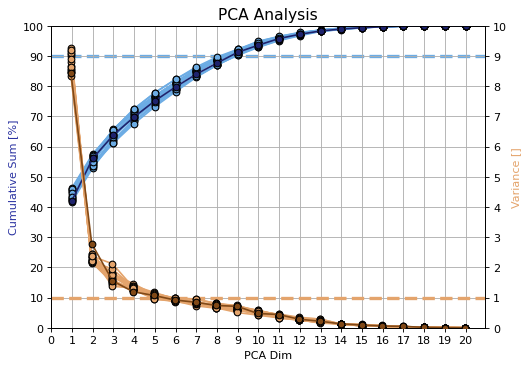

In [ ]:
pca = CaliPCA()
X = np.zeros((2*24*365*15*22, 20))  # Preallocating for a matrix which contains all of the data
location = pd.DataFrame(X[:, 0], columns=['location'])
for i, key in enumerate(locs):
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    # 10e11 b/c sklearn warns about the magnitude of datetime
    df['datetime'] = pd.to_datetime(df.iloc[:, 0:5]).astype(int) / 10e11
    # We don't want to use the year, month, day, hour, minute columns
    # The 'drop' command removes those
    df.drop(df.columns[0:5], axis=1, inplace=True)
    N = df.shape[0]
    X[i*N:(i+1)*N, :] = df  # Filling in at the appropriate indices
    location.iloc[i*N:(i+1)*N, :] = key

    pca.standardize(df)
    pca.rightplot()
    pca.leftplot()

# PCA on entire dataset
pca.standardize(X)
pca.rightplot(c=colors['Orange'], z=3)
pca.leftplot(c=colors['BLUE'], z=3)
pca.props()

From the plot we infer that we can keep over 75% of the variance using only 5 principal components out of 20, which is fantastic, as this will improve training times for our LSTM Model.

We now preprocess the data using PCA and run a LSTM model on every location.

In [ ]:
look_back = 48
look_ahead = 5
pca_n_comp = 5
units = 32

pca = PCA(pca_n_comp)
min_max_scaler = sklearn.preprocessing.MinMaxScaler()


def create_window(data, window_shape, step=1, start_id=None, end_id=None):
    """Generates a window for minibatch training on LSTM model.
    
    Original code from here: https://bit.ly/3a1hBCn, with modifications
    by gt2447/mg3777.
    """
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data,
                                                  shape=new_shape,
                                                  strides=strides)
    
    return np.squeeze(window_data, 1)


def create_model():
    """Generates a LSTM model"""

    model = keras.Sequential()
    model.add(layers.Input(shape=(look_back, pca_n_comp)))
    model.add(layers.LSTM(units=units, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(units=units))
    model.add(layers.Dense(units=units))
    model.add(layers.Dense(units=1))

    return model


model = create_model()
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy'])

for i, location in enumerate(locs.keys()):
    X = pd.read_csv(f'{data_dir}processed/{location}.zip')

    # Processing y_train
    y_train = X.dni
    y_train = y_train.to_numpy()
    y_train = y_train.reshape(-1, 1)
    y_train = sklearn.preprocessing.normalize(y_train)
    y_train = create_window(y_train,
                            window_shape=look_ahead,
                            start_id=look_back)

    # Processing X_train
    scaled = sklearn.preprocessing.scale(X)
    pca.fit_transform(scaled)
    eigenvectors = pca.components_.T
    X_train = X @ eigenvectors
    np_scaled = min_max_scaler.fit_transform(X_train)
    X_train = pd.DataFrame(np_scaled, columns=X_train.columns)
    X_train = create_window(X_train,
                            window_shape=look_back,
                            end_id=-look_ahead)
    
    if i == 0:
        print(f'X_train shape: {X_train.shape}')
        print(f'y_train shape: {y_train.shape}')

    print(location.upper())
    model.fit(x=X_train, 
              y=y_train,
              batch_size=look_back,
              epochs=1,
              validation_split=0.4)

X_train shape: (385388, 48, 5)
y_train shape: (385388, 5, 1)
CHICO
4818/4818 [==============================] - 78s 9ms/step - loss: 0.0745 - accuracy: 0.8963 - val_loss: 0.0545 - val_accuracy: 0.9211
FRESNO
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0531 - accuracy: 0.9235 - val_loss: 0.0506 - val_accuracy: 0.9262
BAKERSFIELD
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0521 - accuracy: 0.9247 - val_loss: 0.0487 - val_accuracy: 0.9296
LOS ANGELES
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0542 - accuracy: 0.9210 - val_loss: 0.0524 - val_accuracy: 0.9239
EUREKA
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0704 - accuracy: 0.8967 - val_loss: 0.0675 - val_accuracy: 0.9007
MERCED
4818/4818 [==============================] - 43s 9ms/step - loss: 0.0527 - accuracy: 0.9229 - val_loss: 0.0478 - val_accuracy: 0.9300
SAN FRANCISCO
4818/4818 [==============================] - 44s 9ms/step - loss: 0.06

It should be noted that using 1 epoch for each location is rather unusual, but the validation accuracy doesn't improve significantly after the first epoch which validates this approach.

This simple architecture of only two LSTM layers with a dropout of 0.5 performed as well as deeper models (10 layers) we tested with no dropout. 

The result is an average validation accuracy for the next five time steps 93% for each location, with a minimum of 90%, using an input size of 48 values (last 24 hours). The high validation accuracy indicates good generalization, and thus a fully satisfactory result. 

# References

[Weather Data](https://www.nrel.gov/grid/solar-resource/renewable-resource-data.html)

[California geospatial raster data](https://data.ca.gov/dataset/ca-geographic-boundaries)



[California shoreline](https://purl.stanford.edu/xv279yj9196)

DNI vs. solar power potential:
M. Schlecht, R. Meyer, 2012. *Site selection and feasibility analysis for concentrating solar power (CSP) systems.* https://doi.org/10.1533/9780857096173.1.91.

James et al. 2013. An Introduction to Statistical Learning w. Applications in R

Christopher Olah. 2015. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/#:~:text=Long%20Short%20Term%20Memory%20networks,many%20people%20in%20following%20work)

Documentation for various packages

Deep Learning. 2016. Goodfellow et al.


